In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader

import torchvision
from torchvision import datasets, transforms
from torchvision.utils import make_grid

print('PyTorch version:', torch.__version__)
print('torchvision version:', torchvision.__version__)
use_gpu = torch.cuda.is_available()
print('Is GPU available:', use_gpu)

PyTorch version: 1.0.0
torchvision version: 0.2.1
Is GPU available: True


In [2]:
# 全体的な設定
batchsize = 128
device = torch.device('cuda' if use_gpu else 'cpu')

# シード値の指定（cuDNN由来のランダム性はこれでも残るようなので注意）
seed = 1
torch.manual_seed(seed)
if use_gpu:
    torch.cuda.manual_seed(seed)

In [3]:
# データセットの準備
# Tensorにしつつ、 (-1 ~ 1)の範囲に正規化
tf = transforms.Compose([transforms.ToTensor(), 
                         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# CIAR10データセットをロードし、上で定義したtransformをかける.。
# 本当はtraining data, validation data, test dataに分けるべきだが、今回は簡便のため2つに分ける.
# 実行するときはこの辺のファイル設定は適宜変更して下さい
cifar10_train = datasets.CIFAR10(root='./data/',
                                 train=True,
                                 transform=tf,
                                 download=False)

cifar10_validation = datasets.CIFAR10(root='./data/',
                                      train=False,
                                      transform=tf)

# num_workersは複数コアがある場合にいくつのコアをデータのロードに使うからしい。影響はよくわからない
cifar10_train_loader = DataLoader(cifar10_train, 
                                  batch_size=batchsize, 
                                  shuffle=True, 
                                  num_workers=4)

cifar10_validation_loader = DataLoader(cifar10_validation, 
                                       batch_size=batchsize, 
                                       shuffle=False, 
                                       num_workers=4)

# cifar10の10個のクラスの名前
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

print('the number of training data:', len(cifar10_train))
print('the number of validation data:', len(cifar10_validation))

the number of training data: 50000
the number of validation data: 10000


tensor([[0, 5, 4, 4, 9],
        [3, 9, 9, 3, 3],
        [0, 7, 0, 5, 5],
        [4, 1, 1, 6, 1],
        [6, 5, 8, 3, 1]])
[['plane' 'dog' 'deer' 'deer' 'truck']
 ['cat' 'truck' 'truck' 'cat' 'cat']
 ['plane' 'horse' 'plane' 'dog' 'dog']
 ['deer' 'car' 'car' 'frog' 'car']
 ['frog' 'dog' 'ship' 'cat' 'car']]


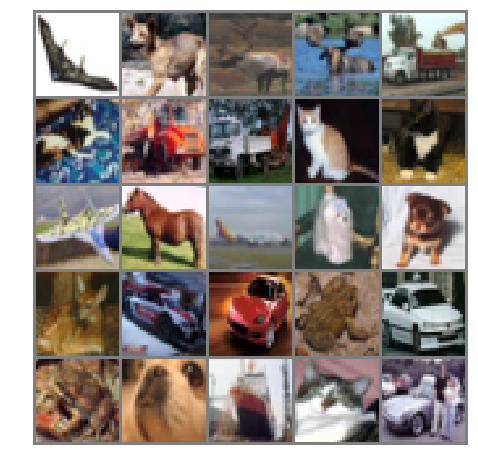

In [4]:
# make_gridを用いた画像データの可視化
def imshow(img):
    npimg = img.numpy() * 0.5 + 0.5 # 描画のために正規化を戻す
    plt.figure(figsize = (8, 8))
    # PyTorchでは画像は(channel, height, width)で, pltでは(height, width, channel)なのでnp.transpose
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    
n_row = 5 # 列数(行数も同じ)
n_show = n_row ** 2 # 表示する画像データの枚数
# iterでDataLoaderを包むと.next()で次のミニバッチを取り出せる
images, labels = iter(cifar10_train_loader).next()
images, labels = images[:n_show], labels[:n_show]

# クラスラベルのインデックスをクラス名に変換
labels_name = np.array([classes[l] for l in labels.numpy()]).reshape(n_row, n_row)
# make_grid()はいい感じに画像を１つにまとめてくれる。 n_rowで列数を指定. paddingは画像同士の間隔
imshow(make_grid(images, nrow = n_row, padding = 1))
plt.axis('off')
print(labels.view(n_row, n_row))
print(labels_name)

In [5]:
# cifar10分類のための畳み込みニューラルネットワーク(かなり適当)
class CNN_CIFAR10(nn.Module):
    def __init__(self):
        super(CNN_CIFAR10, self).__init__()
        # 畳み込みとバッチノルム、活性化関数とプーリングをある程度まとめて扱う
        self.layers1 = nn.Sequential(
                            nn.Conv2d(3, 32, kernel_size=5, stride=1, padding=2),
                            nn.BatchNorm2d(32),
                            nn.ReLU(),
                            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layers2 = nn.Sequential(
                            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
                            nn.BatchNorm2d(64),
                            nn.ReLU(),
                            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layers3 = nn.Sequential(
                            nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2),
                            nn.BatchNorm2d(128),
                            nn.ReLU(),
                            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        #　畳み込み層のあとに１次元にまとめて全結合層に入れ、最終的に１０クラス分類に帰着する
        self.dr1 = nn.Dropout(0.3) # ドロップアウト、引数はノードを無効化する確率（デフォルトは0.5）
        self.fc1 = nn.Linear(128 * 4 * 4, 256)
        self.rl1 = nn.ReLU()
        self.fc2 = nn.Linear(256, 10)
        
    def forward(self, x):
        out = self.layers1(x)
        out = self.layers2(out)
        out = self.layers3(out)
        
        # 畳み込みが終わったので全結合層に入れるために１次元にサイズ変換
        # .viewでサイズを変更。-1は1回だけ指定でき、ワイルドカード的に使う（他の部分の値から自動で計算）
        out = out.view(out.size(0), -1)
        out = self.dr1(out)
        out = self.rl1(self.fc1(out))
        out = self.fc2(out)
        return out

In [6]:
# ネットワークを実体化、ロス関数とオプティマイザを定義
net = CNN_CIFAR10()
net = net.to(device) # .to(device)でCPU/GPUに送信できる

loss_fn = nn.CrossEntropyLoss() # クロスエントロピー誤差. ソフトマックスも含む

learning_rate = 0.001
# オプティマイザはAdam.
# パラメータを渡し、学習率、weight decayの係数を指定（これはoptional）
optimizer = optim.Adam(net.parameters(), lr=learning_rate, weight_decay=2e-5)

# モデルのtarinableな(勾配を要求する)パラメータの数をカウントする（.numel()で要素数の合計がわかる）
num_trainable_params = sum(p.numel() for p in net.parameters() if p.requires_grad)

# モデルの構造、ロス関数、オプティマイザの表示
print('The number of trainable parameters:', num_trainable_params)
print('\nModel:\n', net)
print('\nLoss function:\n', loss_fn)
print('\nOptimizer:\n', optimizer)

The number of trainable parameters: 786186

Model:
 CNN_CIFAR10(
  (layers1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layers2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layers3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (dr1): Dropout(p=0.3)
  (fc1): Linear(in_features=204

In [7]:
# １エポック分の学習を行う関数
def train(train_loader):
    net.train() # モデルを学習モードにする（ドロップアウトの有無などが変わる）
    running_loss = 0
    
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device) # モデルと同じインタフェースでGPU転送
        outputs = net(inputs)
        # outputsとtargetsの順番は変えてはいけない。 後, one-hot-encodingは向こうでやってくれている？
        loss = loss_fn(outputs, targets)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # .item()でスカラ値を0次元Tensorから取り出す。 0次元Tensorへのインデックスアクセスはver1.0からエラー
        running_loss += loss.item() 
    
    # lossはミニバッチサイズ依存がないように正規化されているので、ミニバッチの数で割る
    train_loss = running_loss / len(train_loader)
    return train_loss # 戻り値は訓練誤差

In [8]:
# バリデーションを行う関数
def validation(validation_loader):
    net.eval() # モデルを評価モードにする
    validation_loss = 0
    correct = 0 # 正解数
    
    with torch.no_grad(): # 評価時には不要なので勾配を追跡させない
        for inputs, targets in validation_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            
            validation_loss += loss_fn(outputs, targets).item() # 今回backwardしないので一気にスカラ値に
            preds = outputs.max(1, keepdim=True)[1] # 一番出力ノードの値が大きなもののindex(ラベル)を取得
            correct += preds.eq(targets.view_as(preds)).sum().item() # 正解ラベルと比較し正解数をカウント
    
    validation_loss = validation_loss / len(validation_loader)
    # accuracyはデータの総数で割るので, datasetがつく
    validation_accuracy = correct / len(validation_loader.dataset) 
    return validation_loss, validation_accuracy # ロスと正答率を返す

In [9]:
# 学習の実行と、モデルの保存（学習ログは.npyで、モデル状態は.pthで　←　モデル状態の保存は他にもいろいろある）
SAVE_DIR = './cifar10_result/' # ログと重みをここに保存する
train_loss_list = [] # train lossのログ
validation_loss_list = [] # validation lossのログ
validation_accuracy_list = [] # validation accuracyのログ

n_epochs = 10
for epoch in range(n_epochs):
    train_loss = train(cifar10_train_loader)
    validation_loss, validation_accuracy = validation(cifar10_validation_loader)
    
    train_loss_list.append(train_loss)
    validation_loss_list.append(validation_loss)
    validation_accuracy_list.append(validation_accuracy)
    
    print('epoch[%2d/%2d] loss:%1.4f validation_loss:%1.4f validation_accuracy:%1.4f' % \
                            (epoch+1, n_epochs, train_loss, validation_loss, validation_accuracy))

# ログと重みを保存
if not os.path.exists(SAVE_DIR):
    os.mkdir(SAVE_DIR)
np.save(SAVE_DIR + 'train_loss_list.npy', np.array(train_loss_list))
np.save(SAVE_DIR + 'validation_loss_list.npy', np.array(validation_loss_list))
np.save(SAVE_DIR + 'validation_accuracy_list.npy', np.array(validation_accuracy_list))

# 重みを保存。サイズ結構あるので注意 
# 学習中断→再開したい時は、同じインタフェースでオプティマイザも保存できる(optimizer.state_dict())
torch.save(net.state_dict(), SAVE_DIR + 'CNN_CIFAR10.pth')

epoch[ 1/10] loss:1.2678 validation_loss:0.9761 validation_accuracy:0.6585
epoch[ 2/10] loss:0.9181 validation_loss:0.9566 validation_accuracy:0.6599
epoch[ 3/10] loss:0.7722 validation_loss:0.7834 validation_accuracy:0.7227
epoch[ 4/10] loss:0.6711 validation_loss:0.8060 validation_accuracy:0.7278
epoch[ 5/10] loss:0.6006 validation_loss:0.7232 validation_accuracy:0.7462
epoch[ 6/10] loss:0.5402 validation_loss:0.6736 validation_accuracy:0.7712
epoch[ 7/10] loss:0.4694 validation_loss:0.6194 validation_accuracy:0.7901
epoch[ 8/10] loss:0.4204 validation_loss:0.6587 validation_accuracy:0.7781
epoch[ 9/10] loss:0.3828 validation_loss:0.7062 validation_accuracy:0.7713
epoch[10/10] loss:0.3342 validation_loss:0.6001 validation_accuracy:0.7984


In [10]:
# 学習ログの読み込み（このjupyter notebookを実行する上で必要はないが、np.save/np.loadのメモ）
train_loss_list = np.load(SAVE_DIR + 'train_loss_list.npy')
validation_loss_list = np.load(SAVE_DIR + 'validation_loss_list.npy')
validation_accuracy_list = np.load(SAVE_DIR + 'validation_accuracy_list.npy')

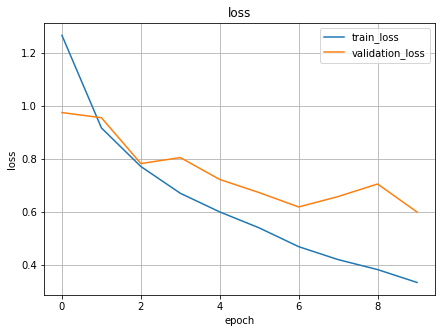

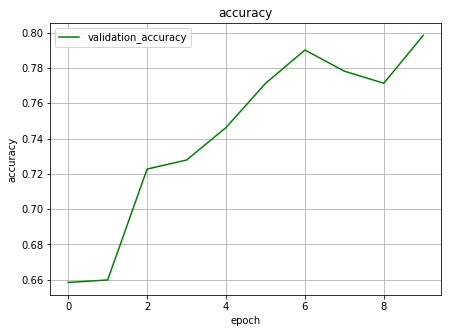

In [11]:
# 学習ログ（lossとaccuracy)の可視化
# loss
plt.figure(figsize = (7, 5))
plt.plot(train_loss_list, label='train_loss')
plt.plot(validation_loss_list, label='validation_loss')
plt.title('loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.grid()
plt.show()

# accuracy
plt.figure(figsize = (7, 5))
plt.plot(validation_accuracy_list, 'g-', label='validation_accuracy')
plt.title('accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.grid()
plt.show()

In [12]:
# モデルの重みの読み込み（このjupyter notebookを実行する上で必要はないが、torch.save/torch.loadメモ）
params = torch.load(SAVE_DIR + 'CNN_CIFAR10.pth')
net = CNN_CIFAR10()
net.load_state_dict(params)

In [13]:
# 読み込んだ学習済みモデルを使って推論のテスト
# ここで用いているデータはvaidationデータと同じなので本来testデータには不適切だが、簡便のため同じものでテスト
cifar10_test = datasets.CIFAR10(root='./data',
                               train=False,
                               transform=tf)

cifar10_test_loader = DataLoader(cifar10_test, 
                                 batch_size=batchsize, 
                                 shuffle=True) # shuffleの有無だけ変更

with torch.no_grad():
    net.eval()
    inputs, targets = iter(cifar10_test_loader).next()
    outputs = net(inputs)
    preds = outputs.max(1, keepdim = True)[1].view(-1)
    accuracy = preds.eq(targets.view_as(preds)).sum().item() / len(inputs)
print('accuracy:%2.2f' % (accuracy*100) + '%')

accuracy:75.00%


prediction:
 [['plane' 'dog' 'plane' 'cat' 'horse']
 ['dog' 'bird' 'frog' 'frog' 'truck']
 ['cat' 'plane' 'plane' 'dog' 'deer']
 ['ship' 'dog' 'ship' 'frog' 'cat']
 ['car' 'plane' 'plane' 'plane' 'car']]
ground truth:
 [['plane' 'dog' 'truck' 'cat' 'horse']
 ['dog' 'bird' 'frog' 'frog' 'truck']
 ['dog' 'ship' 'plane' 'dog' 'deer']
 ['ship' 'plane' 'ship' 'frog' 'cat']
 ['car' 'plane' 'plane' 'plane' 'car']]


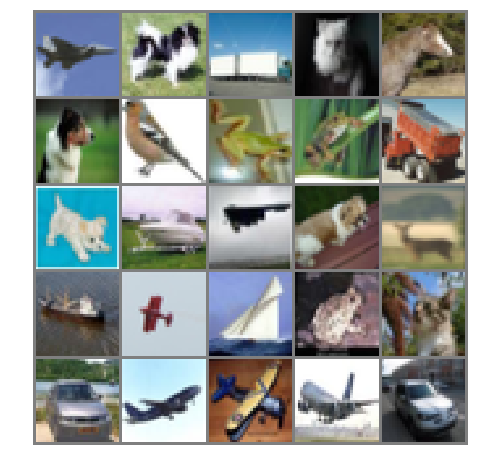

In [14]:
# 推論結果の可視化
n_row = 5 # 列数(行数も同じ)
n_show = n_row ** 2 # 表示する画像データの枚数
images, labels, predict_labels = inputs[:n_show], targets[:n_show], preds[:n_show]

# クラスラベルのインデックスをクラス名に変換
labels_name = np.array([classes[l] for l in labels.numpy()]).reshape(n_row, n_row)
predict_labels_name = np.array([classes[l] for l in predict_labels.numpy()]).reshape(n_row, n_row)

imshow(make_grid(images, nrow = n_row, padding = 1))
plt.axis('off')
print('prediction:\n', predict_labels_name)
print('ground truth:\n', labels_name)

In [15]:
# どんな画像について間違えたのか抽出
wrong_predicted_images = []
correct_labels = []
wrong_predicted_labels = []
wrong_predicted_outputs = []

for i, t, p, o in zip(inputs, targets, preds, outputs):
    if t.item() != p.item():
        wrong_predicted_images.append(i)
        correct_labels.append(t)
        wrong_predicted_labels.append(p)
        wrong_predicted_outputs.append(o)

wrong prediction:
['plane' 'cat' 'plane' 'dog' 'plane']
['deer' 'deer' 'frog' 'truck' 'dog']
['dog' 'dog' 'dog' 'plane' 'car']
['cat' 'dog' 'plane' 'cat' 'frog']
['cat' 'cat' 'plane' 'plane' 'plane']
['truck' 'ship' 'cat' 'cat' 'ship']
['dog' 'bird']

ground truth:
['truck' 'dog' 'ship' 'plane' 'dog']
['bird' 'bird' 'bird' 'ship' 'bird']
['frog' 'cat' 'horse' 'bird' 'plane']
['horse' 'horse' 'cat' 'ship' 'cat']
['deer' 'frog' 'bird' 'bird' 'deer']
['frog' 'plane' 'horse' 'ship' 'car']
['cat' 'cat']


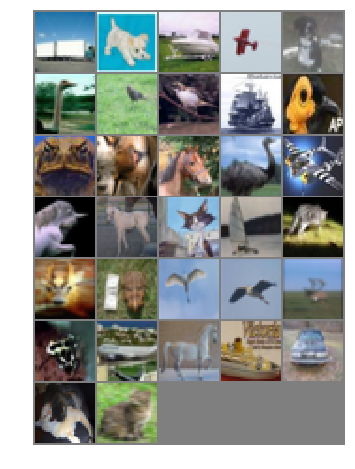

In [16]:
# どんな画像について間違えたのか可視化してみる
correct_labels_name = np.array([classes[l] for l in correct_labels])
wrong_predicted_labels_name = np.array([classes[l] for l in wrong_predicted_labels])

imshow(make_grid(wrong_predicted_images, nrow = n_row, padding = 1))
plt.axis('off')
print('wrong prediction:')
for l in range(0, len(wrong_predicted_labels_name), n_row):
    print(wrong_predicted_labels_name[l:l+n_row])
print()
print('ground truth:')
for l in range(0, len(correct_labels_name), n_row):
    print(correct_labels_name[l:l+n_row])

In [17]:
# 上のまとめた画像において左上から順に確率を表示(％)
# 間違えたものがどれくらいの確率で間違えたのか出力にSoftmaxをかけて見てみる
# 大体人間から見ても似ているものについて間違えており、確率的にもそうなっていることがわかる
predict_prob = []
for wrong_prediction in wrong_predicted_outputs:
    predict_prob.append(F.softmax(wrong_prediction, dim = 0).numpy())
predict_prob = np.array(predict_prob)

predict_prob_dict = {}
for i, c in enumerate(classes):
    predict_prob_dict[c] = predict_prob[:, i] * 100
    
pd.options.display.float_format = '{:.1f}'.format
df = pd.DataFrame(predict_prob_dict)
df

,bird,car,cat,deer,dog,frog,horse,plane,ship,truck
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,75.9,9.7,14.4
1,0.1,0.0,62.7,3.4,33.0,0.4,0.1,0.3,0.0,0.0
2,0.0,2.9,0.0,0.0,0.1,0.0,0.1,93.6,1.6,1.7
3,2.0,0.0,21.9,0.1,70.2,1.6,0.2,2.8,0.8,0.4
4,6.3,0.0,27.2,5.8,6.7,0.7,10.5,32.1,9.8,0.9
5,22.4,0.0,1.7,33.3,0.4,0.1,15.2,12.6,0.7,13.5
6,37.8,0.0,4.9,51.6,2.3,3.1,0.2,0.0,0.0,0.0
7,1.2,11.9,0.1,0.1,0.0,59.3,0.2,25.1,0.5,1.7
8,0.0,0.7,0.2,0.0,0.0,0.1,0.0,0.0,49.5,49.5
9,0.2,0.0,0.4,0.0,99.3,0.0,0.1,0.0,0.0,0.0
